"""
## Script Overview
This script defines a systematic trading workflow, including data engineering, feature extraction, 
machine learning model training, signal generation, and backtesting.

### Major Components:
1. **BaseStrategyModel**: A base class for trading strategies.
2. **Features**: Handles feature engineering and technical indicator generation.
3. **PredictionStrategy**: A backtesting strategy based on predictions.
4. **RandomForest**: Implements a Random Forest-based strategy.
5. **Main Function**: Executes the full workflow from data retrieval to backtesting.

### Dependencies:
- pandas, numpy, matplotlib for data handling and visualization.
- yfinance for downloading stock data.
- scikit-learn for machine learning and feature selection.
- backtesting.py for backtesting trading strategies.
"""


In [9]:
!pip install pandas_ta
!pip install filterpy
!pip install backtesting


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score

from sklearn.feature_selection import SelectKBest, f_classif
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

from backtesting import Backtest, Strategy
from datetime import datetime
from sklearn.tree import plot_tree
import logging
from IPython.display import display, HTML


# Turn off warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### High-Level Overview of the `BaseStrategyModel` Class

The `BaseStrategyModel` class provides a foundational framework for developing and testing trading strategies in a systematic and organized manner. It handles common tasks such as data processing, signal plotting, and result logging, enabling users to focus on the core trading logic. Designed with extensibility in mind, this class serves as a base for building more specialized strategies in financial backtesting workflows.

#### Key Features:
1. **Data Management**: Efficiently integrates with financial data, providing a structured environment for storing and processing inputs.
2. **Signal Visualization**: Includes tools for plotting trading signals (e.g., buy/sell/hold) against historical data for better interpretability.
3. **Result Logging**: Automates the saving of trading results and performance metrics to Excel files, supporting robust record-keeping.
4. **Extensibility**: Abstract methods like `generate_signals()` allow users to define custom logic while reusing the shared functionality.

This class is ideal for traders, data scientists, and researchers who need a reliable foundation to prototype, validate, and iterate on algorithmic trading ideas within a Jupyter Notebook or other Python environments.

In [4]:
class BaseStrategyModel:
       
    """
    ## Class: BaseStrategyModel
    ### Overview:
    A base class for implementing trading strategies. This class provides utilities for data handling, 
    signal plotting, and saving results to Excel, allowing derived classes to focus on specific strategy logic.

    ### Attributes:
    - `model`: The data and model container.
    - `cash` (float): Initial capital for backtesting. Default is 10,000.
    - `commission` (float): Trading commission as a percentage. Default is 0.002 (0.2%).
    - `stop_loss_pct` (float): Stop-loss percentage per trade. Default is 0.05 (5%).
    - `take_profit_pct` (float): Take-profit percentage per trade. Default is 0.2 (20%).
    - `show_plots` (bool): Whether to show plots during execution. Default is `False`.
    - `save_logs` (bool): Whether to save logs to Excel. Default is `False`.

    ### Methods:
    - `generate_signals()`: Abstract method to implement specific signal generation logic in subclasses.
    - `plot_signals()`: Plots the returns, predictions, and trading signals on a timeline.
    - `save_to_excel(position_log=None)`: Saves the data and logs (if provided) to an Excel file.
    - `run()`: Orchestrates signal generation, plotting, backtesting, and result handling.
    """
    def __init__(self, model, cash=10000, commission=0.002,
                 stop_loss_pct=0.05, take_profit_pct=0.2,
                 show_plots=False, save_logs=False, **kwargs):
        self.model = model
        self.cash = cash
        self.commission = commission
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.show_plots = show_plots
        self.save_logs = save_logs
        self.strategy_name = self.__class__.__name__
        self.kwargs = kwargs  # Additional keyword arguments for strategy-specific parameters

    def generate_signals(self):
        raise NotImplementedError("Each strategy must implement the generate_signals method")

    def plot_signals(self):
        """
        ## Method: plot_signals
        ### Description:
        Plots the trading signals (buy/sell/hold) along with predicted and actual returns.

        ### Visualization:
        - A bar chart shows daily returns.
        - A line plot shows predictions.
        - Scatter plots indicate buy (green) and sell (red) signals.

        ### Notes:
        - Requires the `matplotlib` library for plotting.
        """
        # Plot Return, Prediction, and Trading Signals
        plt.figure(figsize=(14, 7))
        # Plot Return as a bar chart
        plt.bar(self.model.data.index, self.model.data['Return'], color='lightgray', label='Return')
        # Plot Prediction as a line
        plt.plot(self.model.data.index, self.model.data['Prediction'], color='blue', label='Prediction', alpha=0.6)
        # Plot Buy Signals
        buy_signals = self.model.data[self.model.data['Signal'] == 'Buy']
        plt.scatter(buy_signals.index, buy_signals['Prediction'], marker='^', color='green', label='Buy Signal', s=100)
        # Plot Sell Signals
        sell_signals = self.model.data[self.model.data['Signal'] == 'Sell']
        plt.scatter(sell_signals.index, sell_signals['Prediction'], marker='v', color='red', label='Sell Signal', s=100)
        # Adding titles and labels
        plt.title('Daily Return, Prediction, and Trading Signals')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def save_to_excel(self, position_log=None):
        """
        ## Method: save_to_excel
        ### Description:
        Saves the processed data and optional position logs to an Excel file.

        ### Parameters:
        - `position_log` (dict, optional): A dictionary containing logged positions during backtesting.

        ### Output:
        - Excel file with the strategy name and timestamp in the filename.

        ### Notes:
        - Handles timezone localization for datetime columns to avoid conflicts during saving.
        """
        output_filename = f"trading_signals_{self.strategy_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"

        # Copy 'data' from the model
        data = self.model.data.copy()

        # Remove timezone info from index
        if data.index.tz is not None:
            data.index = data.index.tz_localize(None)
        
        # Remove timezone from datetime columns in 'data'
        for col in data.select_dtypes(include=['datetime', 'datetimetz']).columns:
            data[col] = data[col].dt.tz_localize(None)

        try:
            if position_log is not None:
                # Convert 'position_log' to DataFrame
                position_log_df = pd.DataFrame(position_log)

                # Ensure 'Date' column is in datetime format and timezone-naive
                if 'Date' in position_log_df.columns:
                    position_log_df['Date'] = pd.to_datetime(position_log_df['Date'])
                    position_log_df['Date'] = position_log_df['Date'].dt.tz_localize(None)
                else:
                    logger.error("'Date' column not found in position_log.")
                    return

                # Set 'Date' as index in position_log_df for merging
                position_log_df.set_index('Date', inplace=True)

                # Rename columns in position_log_df to avoid conflicts
                position_log_df.rename(columns={
                    'Action': 'PL_Action',
                    'Price': 'PL_Price',
                    'Transaction Size': 'PL_Transaction_Size',
                    'Position': 'PL_Position',
                    'PnL': 'PL_PnL',
                    'PnL%': 'PL_PnL%',
                    'Equity': 'PL_Equity',
                    # Add additional renames if there are more overlapping columns
                }, inplace=True)

                # Merge data and position_log_df on index (Date)
                combined_data = data.merge(position_log_df, left_index=True, right_index=True, how='left')
            else:
                combined_data = data.copy()

            # Write the combined data to a single sheet in Excel
            combined_data.to_excel(output_filename, index=True, engine='openpyxl')

            logger.info(f"Data successfully saved to {output_filename}")
        except Exception as e:
            logger.error(f"An error occurred while saving the Excel file: {e}")
        
        
        
    def run(self):
        """
        ## Method: run
        ### Description:
        Executes the workflow for the strategy or model. This includes generating signals, plotting them, 
        preparing data for backtesting, running the backtest, and visualizing results.

        ### Steps:
        1. Generate trading signals.
        2. Plot trading signals (if `show_plots=True`).
        3. Prepare data for backtesting.
        4. Run backtest using the specified strategy class.
        5. Display backtesting results.
        6. Save results and logs (if `save_logs=True`).

        ### Notes:
        - Ensures the data format is compatible with the `backtesting.py` library.
        - Plots results using matplotlib or displays backtest results in an HTML viewer.

        ### Raises:
        - `ValueError`: If essential data (e.g., `Prediction` column) is missing during backtesting.
        """
        print('--------------------------------')
        print(f'Running the {self.strategy_name}')
        print('--------------------------------')

        # Generate signals
        print('Generating the trading signals')
        self.generate_signals()

        # Plot the signals
        if self.show_plots:
            print('Plotting the trading signals')
            self.plot()


        # Prepare data for backtesting
        print('Preparing the data for backtesting')
        data_for_backtest = self.model.data[['Open', 'High', 'Low', 'Close', 'Volume', 'Prediction']].copy()
        data_for_backtest['Prediction'] = data_for_backtest['Prediction'].astype(int)
        data_for_backtest.columns = data_for_backtest.columns.astype(str)
        data_for_backtest.index = pd.to_datetime(data_for_backtest.index)
        data_for_backtest = data_for_backtest.dropna()

        print('Running the backtest')
        bt = Backtest(
            data_for_backtest,
            PredictionStrategy,
            cash=self.cash,
            commission=self.commission,
            exclusive_orders=True
        )
        results = bt.run(
            stop_loss_pct=self.stop_loss_pct,
            take_profit_pct=self.take_profit_pct
        )

        print('--------------------------------')
        print('BACKTESTING RESULTS')
        print('--------------------------------')
        print(results)
        strategy_instance = results._strategy
        position_log = strategy_instance.report_positions()
        # Save logs if required
        if self.save_logs:
            self.save_to_excel(position_log)
            
        print('Plotting the backtest results')
        bt_file = f"backtest_results_{self.strategy_name}_{self.model.ticker}.html"
        bt.plot(filename=bt_file, plot_return=False, open_browser=True, show_legend=False)
        with open(bt_file, "r") as file:
            html_content = file.read()
            display(HTML(html_content))

### High-Level Overview of the `Features` Class

The `Features` class is a comprehensive tool for preparing financial data for trading and machine learning strategies. It integrates data retrieval, feature engineering, and preprocessing into a unified framework, enabling efficient workflows for financial analysis.

#### Key Functions:
1. **Data Retrieval**: 
   - Fetches historical stock data (e.g., open, close, volume) from Yahoo Finance using the `yfinance` library.
   - Ensures data consistency by renaming and cleaning columns.

2. **Feature Engineering**:
   - Generates a wide range of technical indicators, such as moving averages, Bollinger Bands, and RSI.
   - Creates lagged features for predictive modeling.
   - Applies advanced techniques like Kalman filtering to smooth price series.

3. **Preprocessing**:
   - Automatically handles missing data by dropping incomplete rows after feature generation.
   - Maintains a list of all generated features for easy reference.

4. **Visualization**:
   - Provides methods to plot key indicators and the relationships between raw and smoothed data.

#### Key Use Case:
This class is designed for traders, data scientists, and quants who need a streamlined pipeline to prepare and explore financial datasets. It simplifies the process of creating predictive models by offering pre-built feature generation and visualization capabilities.

In [5]:
class Features:
    """
    ## Class: Features
    ### Overview:
    Handles data retrieval, feature engineering, and preprocessing for financial trading strategies.

    ### Purpose:
    - Downloads historical stock data using `yfinance`.
    - Generates technical indicators and engineered features for model training and prediction.

    ### Attributes:
    - `ticker` (str): Stock ticker symbol for data retrieval.
    - `start_date` (str): Start date for data retrieval.
    - `end_date` (str): End date for data retrieval.
    - `data` (pd.DataFrame): DataFrame holding historical price and volume data.
    - `features` (list): List of generated feature names.
    - `selected_features` (list): Top N selected features for model training.
    """
    def __init__(self, ticker, start_date, end_date,):
        """
        Initializes the Features class.

        ### Args:
        - `ticker` (str): Stock ticker symbol.
        - `start_date` (str): Start date for data retrieval in `YYYY-MM-DD` format.
        - `end_date` (str): End date for data retrieval in `YYYY-MM-DD` format.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        
        self.data = pd.DataFrame()
        self.features = []  # List to hold feature names dynamically
        self.selected_features = []  # List to hold top N features
        
        self.grid_search = None
        self.download_data()
        self.create_features()

    def download_data(self):
        """
        ## Method: download_data
        ### Description:
        Downloads historical price and volume data for the specified ticker using the `yfinance` library.

        ### Data Processing:
        - Downloads Open, High, Low, Close, Volume, and Adjusted Close columns.
        - Renames `Adj Close` to `Adj_Close` for consistency.
        - Ensures no missing values remain by using `.dropna()`.

        ### Notes:
        - Data is stored in the `self.data` attribute as a pandas DataFrame.
        - Automatically handles multi-index columns from Yahoo Finance.

        ### Raises:
        - `ValueError`: If the data cannot be downloaded or contains missing values.
        """        
        # Use yfinance to download data
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        # Flatten MultiIndex columns
        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.get_level_values(0)
        self.data.dropna(inplace=True)
        # Ensure consistent column names
        if 'Adj Close' in self.data.columns:
            self.data = self.data.rename(columns={'Adj Close': 'Adj_Close'})
        else:
            self.data['Adj_Close'] = self.data['Close']
        logger.info(f"Downloaded data columns: {self.data.columns}")

    def create_features(self):
        """
        ## Method: create_features
        ### Description:
        Generates technical indicators and engineered features for use in model training.

        ### Features:
        1. **Returns**:
        - Logarithmic daily returns.
        $$
        Return = \ln\left(\frac{P_{t}}{P_{t-1}}\right)
        $$
        2. **Moving Averages**:
        - SMA over various windows (5, 10, 15, etc.).
        3. **Relative Strength Index (RSI)**:
        - RSI over windows of 7, 14, and 21 days.
        4. **Bollinger Bands**:
        - Upper, middle, and lower bands.
        5. **MACD (Moving Average Convergence Divergence)**:
        - MACD, signal line, and histogram.
        6. **ATR (Average True Range)**:
        - Measures market volatility.
        7. **Lag Features**:
        - Lagged prices, volume, and returns.
        8. **Kalman Filter**:
        - Smooths the Close price series for trend analysis.

        ### Notes:
        - Updates the `self.features` list with all feature names.
        - Drops rows with missing values after feature computation.

        ### Raises:
        - `ValueError`: If features cannot be generated due to missing or invalid data.
        """        
        # Calculate Simple Moving Averages
        
        self.data['Return'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        self.features.append('Return')
        
        
        self.data['SMA_5'] = ta.sma(self.data['Close'], length=5)
        self.data['SMA_10'] = ta.sma(self.data['Close'], length=10)
        self.data['SMA_15'] = ta.sma(self.data['Close'], length=15)
        self.data['SMA_20'] = ta.sma(self.data['Close'], length=20)
        self.data['SMA_30'] = ta.sma(self.data['Close'], length=30)
        self.data['SMA_50'] = ta.sma(self.data['Close'], length=50)
        self.data['SMA_75'] = ta.sma(self.data['Close'], length=75)
        self.features.extend(['SMA_5', 'SMA_10', 'SMA_15', 'SMA_20', 'SMA_30', 'SMA_50', 'SMA_75'])

        # Calculate Relative Strength Index
        self.data['RSI_14'] = ta.rsi(self.data['Close'], length=14)
        self.features.append('RSI_14')

                # Calculate Relative Strength Index
        self.data['RSI_7'] = ta.rsi(self.data['Close'], length=7)
        self.features.append('RSI_7')

                # Calculate Relative Strength Index
        self.data['RSI_21'] = ta.rsi(self.data['Close'], length=21)
        self.features.append('RSI_21')
        # Calculate Bollinger Bands
        bb = ta.bbands(self.data['Close'], length=20, std=2)
        self.data = pd.concat([self.data, bb], axis=1)
        bb_columns = bb.columns.tolist()
        self.features.extend(bb_columns)

        # Add MACD (Moving Average Convergence Divergence)
        macd = ta.macd(self.data['Close'])
        self.data = pd.concat([self.data, macd], axis=1)
        self.features.extend(macd.columns.tolist())

        # Add ATR (Average True Range)
        self.data['ATR'] = ta.atr(high=self.data['High'], low=self.data['Low'], close=self.data['Close'], length=14)
        self.features.append('ATR')

        # Add Stochastic Oscillator
        stoch = ta.stoch(high=self.data['High'], low=self.data['Low'], close=self.data['Close'])
        self.data = pd.concat([self.data, stoch], axis=1)
        self.features.extend(stoch.columns.tolist())

        # Add On-Balance Volume (OBV)
        self.data['OBV'] = ta.obv(self.data['Close'], self.data['Volume'])
        self.features.append('OBV')

        # Create Lag Features for Close Price and Volume
        for lag in [1, 2, 3, 5, 10, 20,30]:
            self.data[f'Close_Lag_{lag}'] = self.data['Close'].shift(lag)
            self.data[f'Volume_Lag_{lag}'] = self.data['Volume'].shift(lag)
            self.data[f'Return_Lag_{lag}']= self.data['Return'].shift(lag)
            self.features.extend([f'Close_Lag_{lag}', f'Volume_Lag_{lag}',f'Return_Lag_{lag}'])

        # Add Kalman Filter
        self.data['Kalman_Filter'] = self.kalman_filter_price(self.data['Close'])
        self.features.append('Kalman_Filter')

        # Remove any rows with NaN values after adding indicators
        self.data.dropna(inplace=True)
        logger.info(f"Data columns after adding indicators: {self.data.columns}")

    def kalman_filter_price(self,prices):
        """
        ## Method: kalman_filter_price
        Applies a Kalman filter to smooth the price series.

        ### Args:
        - `prices` (pd.Series): Price data to smooth.

        ### Returns:
        - `predictions` (list): Smoothed price series.
        """
        n = len(prices)
        kf = KalmanFilter(dim_x=2, dim_z=1)
        kf.x = np.array([[prices.iloc[0]], [0.]])  # initial state (location and velocity)
        kf.F = np.array([[1.,1.],
                        [0.,1.]])    # state transition matrix
        kf.H = np.array([[1.,0.]])    # Measurement function
        kf.P *= 1000.                 # covariance matrix
        kf.R = 5                      # state uncertainty
        kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=0.13)  # process uncertainty

        predictions = []
        for z in prices:
            kf.predict()
            kf.update([z])
            predictions.append(kf.x[0][0])

        return predictions


    def plot(self):
        """
        ## Method: plot
        ### Description:
        Visualizes technical indicators and their relationships with price data.

        ### Visualization:
        - **Indicator Groups**:
        - Moving Averages
        - Bollinger Bands
        - RSI
        - MACD
        - ATR
        - Stochastic Oscillator
        - Lagged Features
        - Kalman Filter
        - Each group is plotted on a separate subplot for clarity.
        - Plots Close price alongside relevant indicators (e.g., Moving Averages, Bollinger Bands).

        ### Notes:
        - Requires `matplotlib` for plotting.
        - Automatically adjusts plot size and layout for better readability.
        """
        # Define indicator groups and their plotting functions
        indicator_groups = {
            'Moving Averages': ['SMA_5', 'SMA_10', 'SMA_15', 'SMA_20', 'SMA_30', 'SMA_50', 'SMA_75'],
            'Bollinger Bands': ['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'],
            'RSI': ['RSI_7', 'RSI_14', 'RSI_21'],
            'MACD': ['MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9'],
            'ATR': ['ATR'],
            'Stochastic Oscillator': ['STOCHk_14_3_3', 'STOCHd_14_3_3'],
            'OBV': ['OBV'],
            'Kalman Filter': ['Kalman_Filter'],
            'Returns': ['Return'],
            'Lagged Returns': [f'Return_Lag_{lag}' for lag in [1, 2, 3, 5, 10, 20, 30]],
            'Lagged Close Prices': [f'Close_Lag_{lag}' for lag in [1, 2, 3, 5, 10, 20, 30]],
            'Lagged Volume': [f'Volume_Lag_{lag}' for lag in [1, 2, 3, 5, 10, 20, 30]],    }

        # Function to plot indicator groups
        def plot_indicator_group(group_name, indicators, title_suffix=''):
            plt.figure(figsize=(14, 5))
            if group_name in ['Moving Averages', 'Bollinger Bands', 'Kalman Filter', 'Lagged Close Prices']:
                plt.plot(self.data.index, self.data['Close'], label='Close Price', color='blue')
            for ind in indicators:
                if ind in self.data.columns:
                    plt.plot(self.data.index, self.data[ind], label=ind)
            plt.title(f'{group_name} {title_suffix}')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # Plot selected indicators
        for group_name, indicators in indicator_groups.items():
            plot_indicator_group(group_name, indicators)


    def plot_kalman_filter(self):
        """
        ## Method: plot_kalman_filter
        ### Description:
        Visualizes the Kalman Filter-smoothed price series alongside the original close price.

        ### Visualization:
        - **Close Price**: The raw closing price of the stock.
        - **Kalman Filter**: The smoothed price series.

        ### Notes:
        - Helps in understanding the smoothing effect of the Kalman Filter.
        - Requires `matplotlib` for plotting.
        """
        plt.figure(figsize=(14, 7))
        plt.plot(self.data.index, self.data['Close'], label='Close Price', color='blue')
        plt.plot(self.data.index, self.data['Kalman_Filter'], label='Kalman Filter', color='red')
        plt.title('Close Price vs. Kalman Filter')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### High-Level Overview of the `PredictionStrategy` Class

The `PredictionStrategy` class implements a trading strategy for use with the `backtesting.py` library. It operates based on prediction signals generated by a machine learning model or other external logic. This class provides mechanisms for executing trades, logging activity, and applying risk management through stop-loss and take-profit levels.

#### Key Features:
1. **Signal-Driven Trading**:
   - Executes trades based on prediction signals (`1` for Buy, `0` for Sell).
   - Supports dynamic trading logic using real-time price data.

2. **Risk Management**:
   - Implements fixed stop-loss and take-profit thresholds to minimize losses and lock in profits.
   - Offers optional trailing stop-loss functionality for adaptive risk control.

3. **Detailed Trade Logging**:
   - Records each trade's action, price, position, and performance metrics (e.g., PnL and equity).
   - Facilitates detailed analysis of strategy performance through structured logs.

4. **Integration with Backtesting Framework**:
   - Designed to seamlessly work within the `backtesting.py` library.
   - Provides methods for initializing strategy parameters, executing trading logic for each time step, and exporting trade data.

#### Key Use Case:
This class is ideal for traders, quants, and researchers looking to backtest prediction-based trading strategies. Its flexibility in signal integration and robust risk management make it a powerful tool for validating and refining algorithmic trading systems.

In [6]:
class PredictionStrategy(Strategy):
    """
    ## Class: PredictionStrategy
    ### Overview:
    A strategy class designed for use with the `backtesting.py` library. Trades are executed based on 
    prediction signals generated by a model (e.g., Random Forest).

    ### Attributes:
    - `stop_loss_pct` (float): Stop-loss percentage per trade. Default is `0.025` (2.5%).
    - `take_profit_pct` (float): Take-profit percentage per trade. Default is `0.25` (25%).
    - `trailing_stop` (bool): Enables or disables a trailing stop-loss mechanism.

    ### Methods:
    - `init()`: Initializes strategy parameters and creates the prediction signal.
    - `next()`: Executes trading logic for each bar in the backtest.
    - `log_position()`: Logs the details of trades, including action, date, price, and PnL.
    - `report_positions()`: Returns the logged positions as a list of dictionaries.

    ### Notes:
    - Uses prediction signals (`1` for Buy, `0` for Sell).
    - Supports trailing stop-loss to protect gains dynamically.
    """
    stop_loss_pct = 0.025  # Default value
    take_profit_pct = 0.25  # Default value
    trailing_stop = False  # Toggle for enabling/disabling trailing stop-loss
    
    def init(self):
        """
        ## Method: init
        ### Description:
        Initializes the strategy. Configures the following:
        - Prediction signal from the data.
        - Position log for recording trades.
        - Current trading action and position details.
        - Trailing stop-loss price, if enabled.

        ### Notes:
        - The prediction signal is converted to integers for compatibility.
        - Logs are stored in `self.position_log` for later retrieval.
        """
        self.prediction = self.I(lambda: self.data['Prediction'].astype(int).tolist())
        self.position_log = []
        self.action = 'Trading Starts'
        self.current_position = 0
        self.trailing_sl_price = None 
        
    def next(self):
        """
        ## Method: next
        ### Description:
        Executes the trading logic for the current bar in the backtest.

        ### Logic:
        1. **Trailing Stop-Loss (if enabled)**:
        - Updates the trailing stop-loss price when the current price rises.
        - Closes the position if the price falls below the trailing stop-loss.
        2. **Signal-Based Trading**:
        - Buys when the prediction signal is `1` and no position is held.
        - Sells when the prediction signal is `0` and a position is held.
        3. **Hold**:
        - Maintains the current position when no trade is required.

        ### Notes:
        - Logs all trading actions, including price, position size, and PnL.
        - Uses fixed stop-loss and take-profit levels unless trailing stop-loss is enabled.
        """        
        if self.action != 'Trading Starts':
            self.log_position()
        current_prediction = self.prediction[-1]

        if self.position.size > 0 and self.trailing_stop:
            # Update the trailing stop-loss price only if the price moves higher
            current_price = self.data.Close[-1]
            potential_new_sl = current_price * (1 - self.stop_loss_pct)
            
            if self.trailing_sl_price is None:
                self.trailing_sl_price = potential_new_sl
            elif current_price > self.trailing_sl_price / (1 - self.stop_loss_pct):
                self.trailing_sl_price = max(self.trailing_sl_price, potential_new_sl)

            # Close the position if the price falls below the trailing stop-loss
            if current_price < self.trailing_sl_price:
                self.position.close()
                self.trailing_sl_price = None  # Reset trailing stop-loss price
                self.action = 'Trailing Stop Loss Triggered'
                return

        if current_prediction == 1 and self.position.size == 0:
            self.current_position = self.position.size
            # Use fixed stop-loss and take-profit
            self.buy(sl=self.data.Close[-1] * (1 - self.stop_loss_pct),
                     tp=self.data.Close[-1] * (1 + self.take_profit_pct))
            self.action = 'Buy'
            if self.trailing_stop:
                # Initialise the trailing stop-loss price
                self.trailing_sl_price = self.data.Close[-1] * (1 - self.stop_loss_pct)
        elif current_prediction == 0 and self.position.size > 0:
            self.current_position = self.position.size
            self.position.close()
            self.trailing_sl_price = None  # Reset trailing stop-loss price
            self.action = 'Sell'
        else:
            self.action = 'Hold'

    def log_position(self):
        """
        ## Method: log_position
        ### Description:
        Records details of the current trade or position in the `position_log`.

        ### Logged Information:
        - `Action`: Trading action ('Buy', 'Sell', 'Hold', or 'Trailing Stop Loss Triggered').
        - `Date`: Current bar's date.
        - `Price`: Current price.
        - `Transaction Size`: Number of shares traded.
        - `Position`: Current position size after the action.
        - `PnL`: Profit or Loss for the current position.
        - `PnL%`: Percentage Profit or Loss.
        - `Equity`: Current account equity.

        ### Notes:
        - Appends logs as dictionaries to the `position_log` list.
        """        
        self.position_log.append({
            'Action': self.action,
            'Date': self.data.index[-1],
            'Price': self.data.Close[-1],
            'Transaction Size': self.current_position,
            'Position': self.position.size,
            'PnL': self.position.pl,
            'PnL%': self.position.pl_pct,
            'Equity': self.equity
        })

    def report_positions(self):
        """
        ## Method: report_positions
        ### Description:
        Returns the logged positions from `position_log` as a list of dictionaries.

        ### Notes:
        - Useful for analysis or saving trade details after backtesting.
        """        
        return self.position_log

### High-Level Overview of the `RandomForest` Class

The `RandomForest` class implements a machine-learning-based trading strategy leveraging the Random Forest algorithm. It is built on the `BaseStrategyModel` class, inheriting its backtesting and plotting capabilities while extending functionality to include training, prediction, and trading signal generation.

#### Key Features:
1. **Machine Learning Integration**:
   - Uses a Random Forest classifier to predict buy/sell signals based on historical market data.
   - Supports hyperparameter optimization to fine-tune model performance.

2. **Feature Engineering and Selection**:
   - Leverages engineered features from a `Features` object, selecting the most predictive ones for training.
   - Dynamically adapts the model to focus on relevant features using feature importance metrics.

3. **Supervised Learning Workflow**:
   - Generates target labels (buy/sell signals) based on future cumulative returns.
   - Splits data into training and testing sets using time-series cross-validation to ensure robustness.

4. **Risk Management and Backtesting**:
   - Executes trades using the `backtesting.py` library with configurable stop-loss, take-profit, and trailing stop-loss mechanisms.
   - Supports backtesting to evaluate strategy performance on historical data.

5. **Visualization**:
   - Plots decision trees from the Random Forest model for interpretability.
   - Generates detailed plots for strategy performance and indicator visualization.

6. **Extensibility**:
   - Can be tailored to different feature sets, hyperparameters, and backtesting configurations, making it suitable for a wide range of financial instruments and markets.

#### Key Use Case:
The `RandomForest` class is ideal for quants and researchers who want to integrate machine learning into their trading strategies. By combining predictive modeling with backtesting and visualization, it allows users to systematically design, evaluate, and refine algorithmic trading systems.

In [7]:
class RandomForest(BaseStrategyModel):
    """
    ## Class: RandomForest
    ### Overview:
    Implements a Random Forest-based trading strategy. This class uses engineered features to train a 
    predictive model and generate buy/sell signals for backtesting.

    ### Attributes:
    - `number_of_features` (int, optional): Number of features to use for training. If `None`, all available features are used.
    - `features` (dict, optional): A dictionary specifying which features to include in the model.
    - `run_hyperparameter_optimization` (bool): Flag to enable or disable hyperparameter optimization.
    - `n_splits` (int): Number of splits for time-series cross-validation.
    - `trailing_stop` (bool): Whether to enable trailing stop-loss.

    ### Methods:
    - `generate_targets()`: Defines target labels based on cumulative returns over a window.
    - `prepare_training_data()`: Splits data into training and testing sets using time-series cross-validation.
    - `optimize_hyperparameters(X_train, y_train)`: Performs hyperparameter optimization using GridSearchCV.
    - `generate_predictions()`: Generates buy/sell signals based on trained model predictions.
    - `plot_tree()`: Visualizes a single decision tree from the trained Random Forest model.
    """    
    
    def __init__(self, model,number_of_features=None,features=None,cash=10000, commission=0.002,stop_loss_pct=0.05,
                    take_profit_pct=0.2,show_plots=False,save_logs=False,run_hyperparameter_optimization=False,n_splits=None,trailing_stop=False):
        """
        Initializes the RandomForest class.

        ### Args:
        - `model` (Features): Features object containing data and engineered features.
        - `number_of_features` (int): Number of top features to use for training.
        - `features` (dict): Dictionary specifying which features to include.
        - `cash` (float): Initial trading capital.
        - `commission` (float): Commission rate for trades.
        - `stop_loss_pct` (float): Stop-loss percentage.
        - `take_profit_pct` (float): Take-profit percentage.
        - `show_plots` (bool): Enable/disable visualization.
        - `save_logs` (bool): Enable/disable saving logs to Excel.
        - `run_hyperparameter_optimization` (bool): Enable/disable hyperparameter tuning.
        - `n_splits` (int): Number of time-series splits for cross-validation.
        - `trailing_stop` (bool): Enable/disable trailing stop-loss.
        """
        self.model = model
        self.cash = cash
        self.commission = commission
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.show_plots = show_plots
        self.save_logs = save_logs
        self.n_splits = n_splits
        self.run_hyperparameter_optimization = run_hyperparameter_optimization
        self.trailing_stop = trailing_stop
        self.strategy_name = f'random_forest_{model.ticker}'
        if features is not None:
            self.selected_features = [feature for feature, use in features.items() if use]
            self.number_of_features = len(self.selected_features)
        else:
            # Use number_of_features if features is not provided
            if number_of_features is None:
                self.number_of_features = len(model.features)
            else:
                self.number_of_features = number_of_features
            self.selected_features = model.features[:self.number_of_features]
        #INFO:__main__:Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1,
        # 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'selectkbest__k': 5}
        self.rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2,class_weight=None, random_state=42,
                                                    max_features='sqrt',min_samples_leaf=1)

    def generate_targets(self):
        """
        ## Method: generate_targets
        ### Description:
        Generates target labels for supervised learning. Targets are based on whether future cumulative returns 
        exceed a specified threshold.

        ### Calculation:
        - Future cumulative return:
        $$
        Future\_Return = \sum_{i=t+1}^{t+n} Return_i
        $$
        Where \( n \) is the return window.

        - Target:
        - `1` if `Future_Return > threshold`
        - `0` otherwise

        ### Notes:
        - Adds a `Future_Return_Sum` column to the data.
        - Adds a `Target` column to the data.
        """
        threshold = 0.005  # 0.5% return threshold
        return_window = 6
        
        self.model.data['Future_Return_Sum'] = self.model.data['Return'].shift(-1).rolling(window=return_window).sum()
        self.model.data['Target'] = np.where(self.model.data['Future_Return_Sum'] > threshold, 1, 0)

    def prepare_training_data(self):
        """
        ## Method: prepare_training_data
        Splits the data into training and testing sets using time-series cross-validation.

        ### Returns:
        - `X_train`, `X_test` (pd.DataFrame): Training and testing features.
        - `y_train`, `y_test` (pd.Series): Training and testing targets.
        """
        # Prepare features and target variable

        X = self.model.data[self.selected_features]
        y = self.model.data['Target']

        # Remove rows with NaN values in target
        self.model.data.dropna(subset=['Target'], inplace=True)
        X = X.loc[self.model.data.index]
        y = y.loc[self.model.data.index]

        # Use time series split for realistic model validation
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        train_indices, test_indices = next(tscv.split(X))
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

        return X_train, X_test, y_train, y_test
    
    def select_top_features(self, X):
        """
        ## Method: select_top_features
        ### Description:
        Selects the top features for training and prediction based on their importance.

        ### Args:
        - `X` (pd.DataFrame): The feature dataset.

        ### Returns:
        - `pd.DataFrame`: Dataset filtered to include only the top-selected features.

        ### Notes:
        - Relies on `self.selected_features`, which is populated during the training phase.
        - Raises an error if `self.selected_features` is empty or uninitialized.
        """
        # Ensure that selected_features is populated
        if not self.selected_features:
            raise ValueError("Top features have not been selected. Ensure train_model is called first.")
        return X[self.selected_features]

    def evaluate_model(self, X_test, y_test):
        """
        ## Method: evaluate_model
        ### Description:
        Evaluates the trained Random Forest model's performance on the test dataset.

        ### Args:
        - `X_test` (pd.DataFrame): Testing feature set.
        - `y_test` (pd.Series): True labels for the testing set.

        ### Outputs:
        - Logs model accuracy and classification report using `sklearn` metrics.

        ### Notes:
        - Outputs are logged to the console for analysis.
        - Ensures predictions are consistent with the model's training features.
    """
        y_pred = self.rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        logger.info(f"Accuracy Score: {accuracy}")
        logger.info(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    def optimize_hyperparameters(self, X_train, y_train):
        """
        ## Method: optimize_hyperparameters
        ### Description:
        Performs hyperparameter tuning for the Random Forest model using GridSearchCV.

        ### Parameters:
        - `X_train` (pd.DataFrame): Training feature set.
        - `y_train` (pd.Series): Training target labels.

        ### Grid Search Parameters:
        - `n_estimators`: [100, 150, 200, 250, 300, 400]
        - `max_depth`: [5, 10, 15, 20, None]
        - `min_samples_split`: [2, 3, 4, 5]
        - `min_samples_leaf`: [1, 2, 5]
        - `max_features`: ['sqrt', 'log2']
        - `class_weight`: ['balanced', None]
        - `k`: [5, 10, All Features]

        ### Notes:
        - Uses a time-series split for cross-validation.
        - Updates the model with the best parameters found.
        """
        # Ensure that selected_features is populated
        if not self.selected_features:
            raise ValueError("Top features have not been selected. Ensure train_model is called first.")

        # Dynamically determine the maximum number of features available for selection
        n_features = len(self.selected_features)
        k_values = [min(5, n_features), min(10, n_features), n_features]

        param_grid = {
                'classifier__n_estimators': [100, 150, 200, 250, 300, 400],
                'classifier__max_depth': [5, 10, 15, 20, None],
                'classifier__min_samples_split': [2, 3, 4, 5],
                'classifier__min_samples_leaf': [1, 2, 5],
                'classifier__max_features': ['sqrt', 'log2'],
                'classifier__class_weight': ['balanced', None],  # Corrected prefix
                'selectkbest__k': k_values
                    }

        # Create a pipeline with StandardScaler, SelectKBest, and RandomForestClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selectkbest', SelectKBest(score_func=f_classif)),
            ('classifier', RandomForestClassifier(random_state=42))
        ])
        print(pipeline.get_params().keys())
        tscv = TimeSeriesSplit(n_splits=5)
        scorer = make_scorer(
                    precision_score,
                    pos_label=1,
                    average='binary',
                    zero_division=0  # or use 1 to set undefined precision to 1.0
                )
        grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=tscv,
                scoring=scorer,
                n_jobs=-1
            )

        # Use the local variable grid_search
        grid_search.fit(X_train[self.selected_features], y_train)

        logger.info(f"Best parameters: {grid_search.best_params_}")
        logger.info(f"Best cross-validation score: {grid_search.best_score_}")

        # Extract classifier parameters from the best parameters
        best_params = {
            k.split('__')[1]: v for k, v in grid_search.best_params_.items() if k.startswith('classifier__')
        }

        # Update the classifier with the best parameters
        self.rf_classifier = RandomForestClassifier(**best_params, random_state=42)
        self.rf_classifier.fit(X_train[self.selected_features], y_train)

    def generate_predictions(self):
        """
        ## Method: generate_predictions
        Generates buy/sell signals based on the trained Random Forest model.

        ### Notes:
        - Adds `Prediction` and `Signal` columns to the dataset.
        - `Prediction`: 1 for Buy, 0 for Sell.
        - `Signal`: String representation of the action ('Buy' or 'Sell').
        """
        # Ensure the feature order is consistent with training
        prediction_features = self.model.data[self.selected_features]
        prediction_features = prediction_features[self.rf_classifier.feature_names_in_]

        # Use only the selected top N features
        self.model.data['Prediction'] = self.rf_classifier.predict(prediction_features)
        self.model.data['Signal'] = np.where(self.model.data['Prediction'] == 1, 'Buy', 'Sell')
        logger.info("Trading signals generated.")
        
    def plot_tree(self):
        """
        ## Method: plot_tree
        Visualizes one of the decision trees from the Random Forest model.

        ### Notes:
        - Saves the tree plot as a PNG image.
        """
        estimator = self.rf_classifier.estimators_[0]
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=300)
        plot_tree(
            estimator,
            feature_names=self.selected_features,
            class_names=['Sell', 'Buy'],
            filled=True,
            max_depth=4
        )
        fig.savefig('rf_individualtree.png')
        logger.info("Decision tree plot saved.")
        
    def train_model(self, X_train, y_train):
        """
        ## Method: train_model
        Trains the Random Forest model using the provided training data.

        ### Args:
        - `X_train` (pd.DataFrame): Training feature set.
        - `y_train` (pd.Series): Training target labels.

        ### Notes:
        - Calculates and logs feature importance.
        - Selects the top `N` features based on importance, where `N` is defined by `number_of_features`.
        """
        self.rf_classifier.fit(X_train, y_train)
        logger.info("Model training complete.")

        # Calculate feature importances
        importances = self.rf_classifier.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        })
        feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
        logger.info(f"Feature Importances:\n{feature_importance_df}")

        # Select the top N features based on importance
        self.selected_features = feature_importance_df['Feature'].iloc[:self.number_of_features].tolist()
        logger.info(f"Top {self.number_of_features} features: {self.selected_features}")

        
    def run(self):
        """
        ## Method: run
        Executes the Random Forest strategy workflow:
        1. Generates targets for supervised learning.
        2. Prepares training and testing datasets.
        3. Trains the model and selects top features.
        4. Generates predictions and backtests the strategy.

        ### Workflow:
        - If `run_hyperparameter_optimization` is enabled, performs hyperparameter tuning before final training.
        - Evaluates the model on the test set.
        - Runs backtesting and logs the results.
        """
        print('--------------------------------')
        print('Running the Random Forest Model')
        print('--------------------------------')
        
        self.generate_targets()
        print('Preparing the data')
        X_train, X_test, y_train, y_test = self.prepare_training_data()

        # Check if specific features are provided
        if self.selected_features:
            # Use the provided features directly
            print('Using provided features for training')
            X_train_top = self.select_top_features(X_train)
            self.train_model(X_train_top, y_train)
            X_test_top = self.select_top_features(X_test)
        else:
            # Initial training to get feature importances
            print('Training the model to determine top features')
            self.train_model(X_train, y_train)
            
            # Select top N features
            print('Selecting the top features')
            X_train_top = self.select_top_features(X_train)
            X_test_top = self.select_top_features(X_test)

        # Ensure the feature order is consistent
        X_test_top = X_test_top[X_train_top.columns]

        # Retrain the model with the selected features
        print('Retraining the model with the selected features')
        self.rf_classifier.fit(X_train_top, y_train)
        logger.info("Model retrained with selected features.")

        # Evaluate the model
        print('Evaluating the model')
        self.evaluate_model(X_test_top, y_test)
            # Continue with optimization, generating signals, and backtesting
        if self.run_hyperparameter_optimization:
            print('Optimizing the hyperparameters')
            self.optimize_hyperparameters(X_train_top, y_train)
            
        print('Generating the trading signals')
        self.generate_predictions()
        
        
        # Prepare data for backtesting
        print('Preparing the data for backtesting')
        data_for_backtest = self.model.data[['Open', 'High', 'Low', 'Close', 'Volume', 'Prediction']].copy()
        data_for_backtest['Prediction'] = data_for_backtest['Prediction'].astype(int)
        data_for_backtest.columns = data_for_backtest.columns.astype(str)
        data_for_backtest.index = pd.to_datetime(data_for_backtest.index)
        data_for_backtest = data_for_backtest.dropna()

        print('Running the backtest')
        bt = Backtest(data_for_backtest, PredictionStrategy, cash=self.cash, commission=self.commission, exclusive_orders=True)
        results = bt.run(stop_loss_pct=self.stop_loss_pct, take_profit_pct=self.take_profit_pct,trailing_stop=self.trailing_stop)
        
        print('=====================================================================================')
        print(f'BACKTESTING RESULTS FOR {self.model.ticker}: Strategy Name: {self.strategy_name}')
        print('=====================================================================================')
        print(results)
        
        print('Plotting the decision tree')
        if self.show_plots: 
            self.plot_tree()
        
        strategy_instance = results._strategy
        position_log = strategy_instance.report_positions() 

        
        if self.save_logs:
            self.save_to_excel(position_log)
        
        print('Plotting the model')
        if self.show_plots:
            self.model.plot()
      
        
        print('Plotting the backtest results')
        bt_file = f"backtest_results_random_forest_{self.model.ticker}.html"
        bt.plot(filename=bt_file,plot_return=False,open_browser=True,show_legend=False)
        with open(bt_file, "r") as file:
            html_content = file.read()
            display(HTML(html_content))

### High-Level Overview of the `main` Function

The `main` function is the entry point for executing a financial trading strategy using machine learning. It is designed to streamline the workflow of retrieving data, preparing features, and running a strategy model, specifically the `RandomForest` strategy.

#### Key Responsibilities:
1. **Parameter Configuration**:
   - Specifies key trading and strategy parameters, such as the stock ticker (`ticker`), data range (`start_date` and `end_date`), and trading settings (`cash`, `commission`, etc.).
   - Defines feature engineering settings through the `features` dictionary, enabling customization of the data used for training.

2. **Data Preparation**:
   - Initializes a `Features` object to download historical stock data and generate technical indicators and lagged features for machine learning.

3. **Strategy Execution**:
   - Configures and executes the `RandomForest` strategy, handling:
     - Target generation based on future returns.
     - Model training and feature selection.
     - Hyperparameter optimization (optional).
     - Signal generation and backtesting.

4. **Visualization and Logging**:
   - Generates visual outputs, such as decision tree plots and backtesting results, to provide insights into strategy performance.
   - Saves results, including trading logs and signals, to files if the `save_logs` flag is enabled.

#### Key Use Case:
This function provides a scalable and modular workflow for building and testing machine learning-based trading strategies. By enabling customization through hardcoded parameters and feature selection, it serves as a foundation for developing and refining trading models.

#### Notes:
- The workflow is configured to run the `RandomForest` strategy, but it can be extended to support other models by modifying the `model_to_run` parameter and associated logic.
- Outputs are designed to be Jupyter Notebook-friendly, facilitating quick analysis and visualization for quants and researchers.

[*********************100%***********************]  1 of 1 completed
INFO:__main__:Downloaded data columns: Index(['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
INFO:__main__:Data columns after adding indicators: Index(['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'SMA_5', 'SMA_10', 'SMA_15', 'SMA_20', 'SMA_30', 'SMA_50', 'SMA_75',
       'RSI_14', 'RSI_7', 'RSI_21', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0',
       'BBB_20_2.0', 'BBP_20_2.0', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'ATR', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'OBV',
       'Close_Lag_1', 'Volume_Lag_1', 'Return_Lag_1', 'Close_Lag_2',
       'Volume_Lag_2', 'Return_Lag_2', 'Close_Lag_3', 'Volume_Lag_3',
       'Return_Lag_3', 'Close_Lag_5', 'Volume_Lag_5', 'Return_Lag_5',
       'Close_Lag_10', 'Volume_Lag_10', 'Return_Lag_10', 'Close_Lag_20',
       'Volume_Lag_20', 'Return_Lag_20', 'Close_Lag_30', 'Volume_Lag_30',
       'Return_Lag_30', '

--------------------------------
Running the Random Forest Model
--------------------------------
Preparing the data
Using provided features for training
Retraining the model with the selected features


INFO:__main__:Model retrained with selected features.
INFO:__main__:Accuracy Score: 0.6709844559585493
INFO:__main__:Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       224
           1       0.59      0.72      0.65       162

    accuracy                           0.67       386
   macro avg       0.67      0.68      0.67       386
weighted avg       0.69      0.67      0.67       386

INFO:__main__:Trading signals generated.


Evaluating the model
Generating the trading signals
Preparing the data for backtesting
Running the backtest
BACKTESTING RESULTS FOR TEAM: Strategy Name: random_forest_TEAM
Start                     2020-04-20 00:00...
End                       2024-11-22 00:00...
Duration                   1677 days 00:00:00
Exposure Time [%]                   61.259707
Equity Final [$]                 37337.999594
Equity Peak [$]                  37337.999594
Return [%]                         273.379996
Buy & Hold Return [%]               70.726579
Return (Ann.) [%]                   33.168689
Volatility (Ann.) [%]               49.554346
Sharpe Ratio                          0.66934
Sortino Ratio                        1.495864
Calmar Ratio                         0.883664
Max. Drawdown [%]                  -37.535418
Avg. Drawdown [%]                   -5.885029
Max. Drawdown Duration      790 days 00:00:00
Avg. Drawdown Duration       56 days 00:00:00
# Trades                                  133


INFO:__main__:Decision tree plot saved.
INFO:__main__:Data successfully saved to trading_signals_random_forest_TEAM_20241124_221908.xlsx


Plotting the model


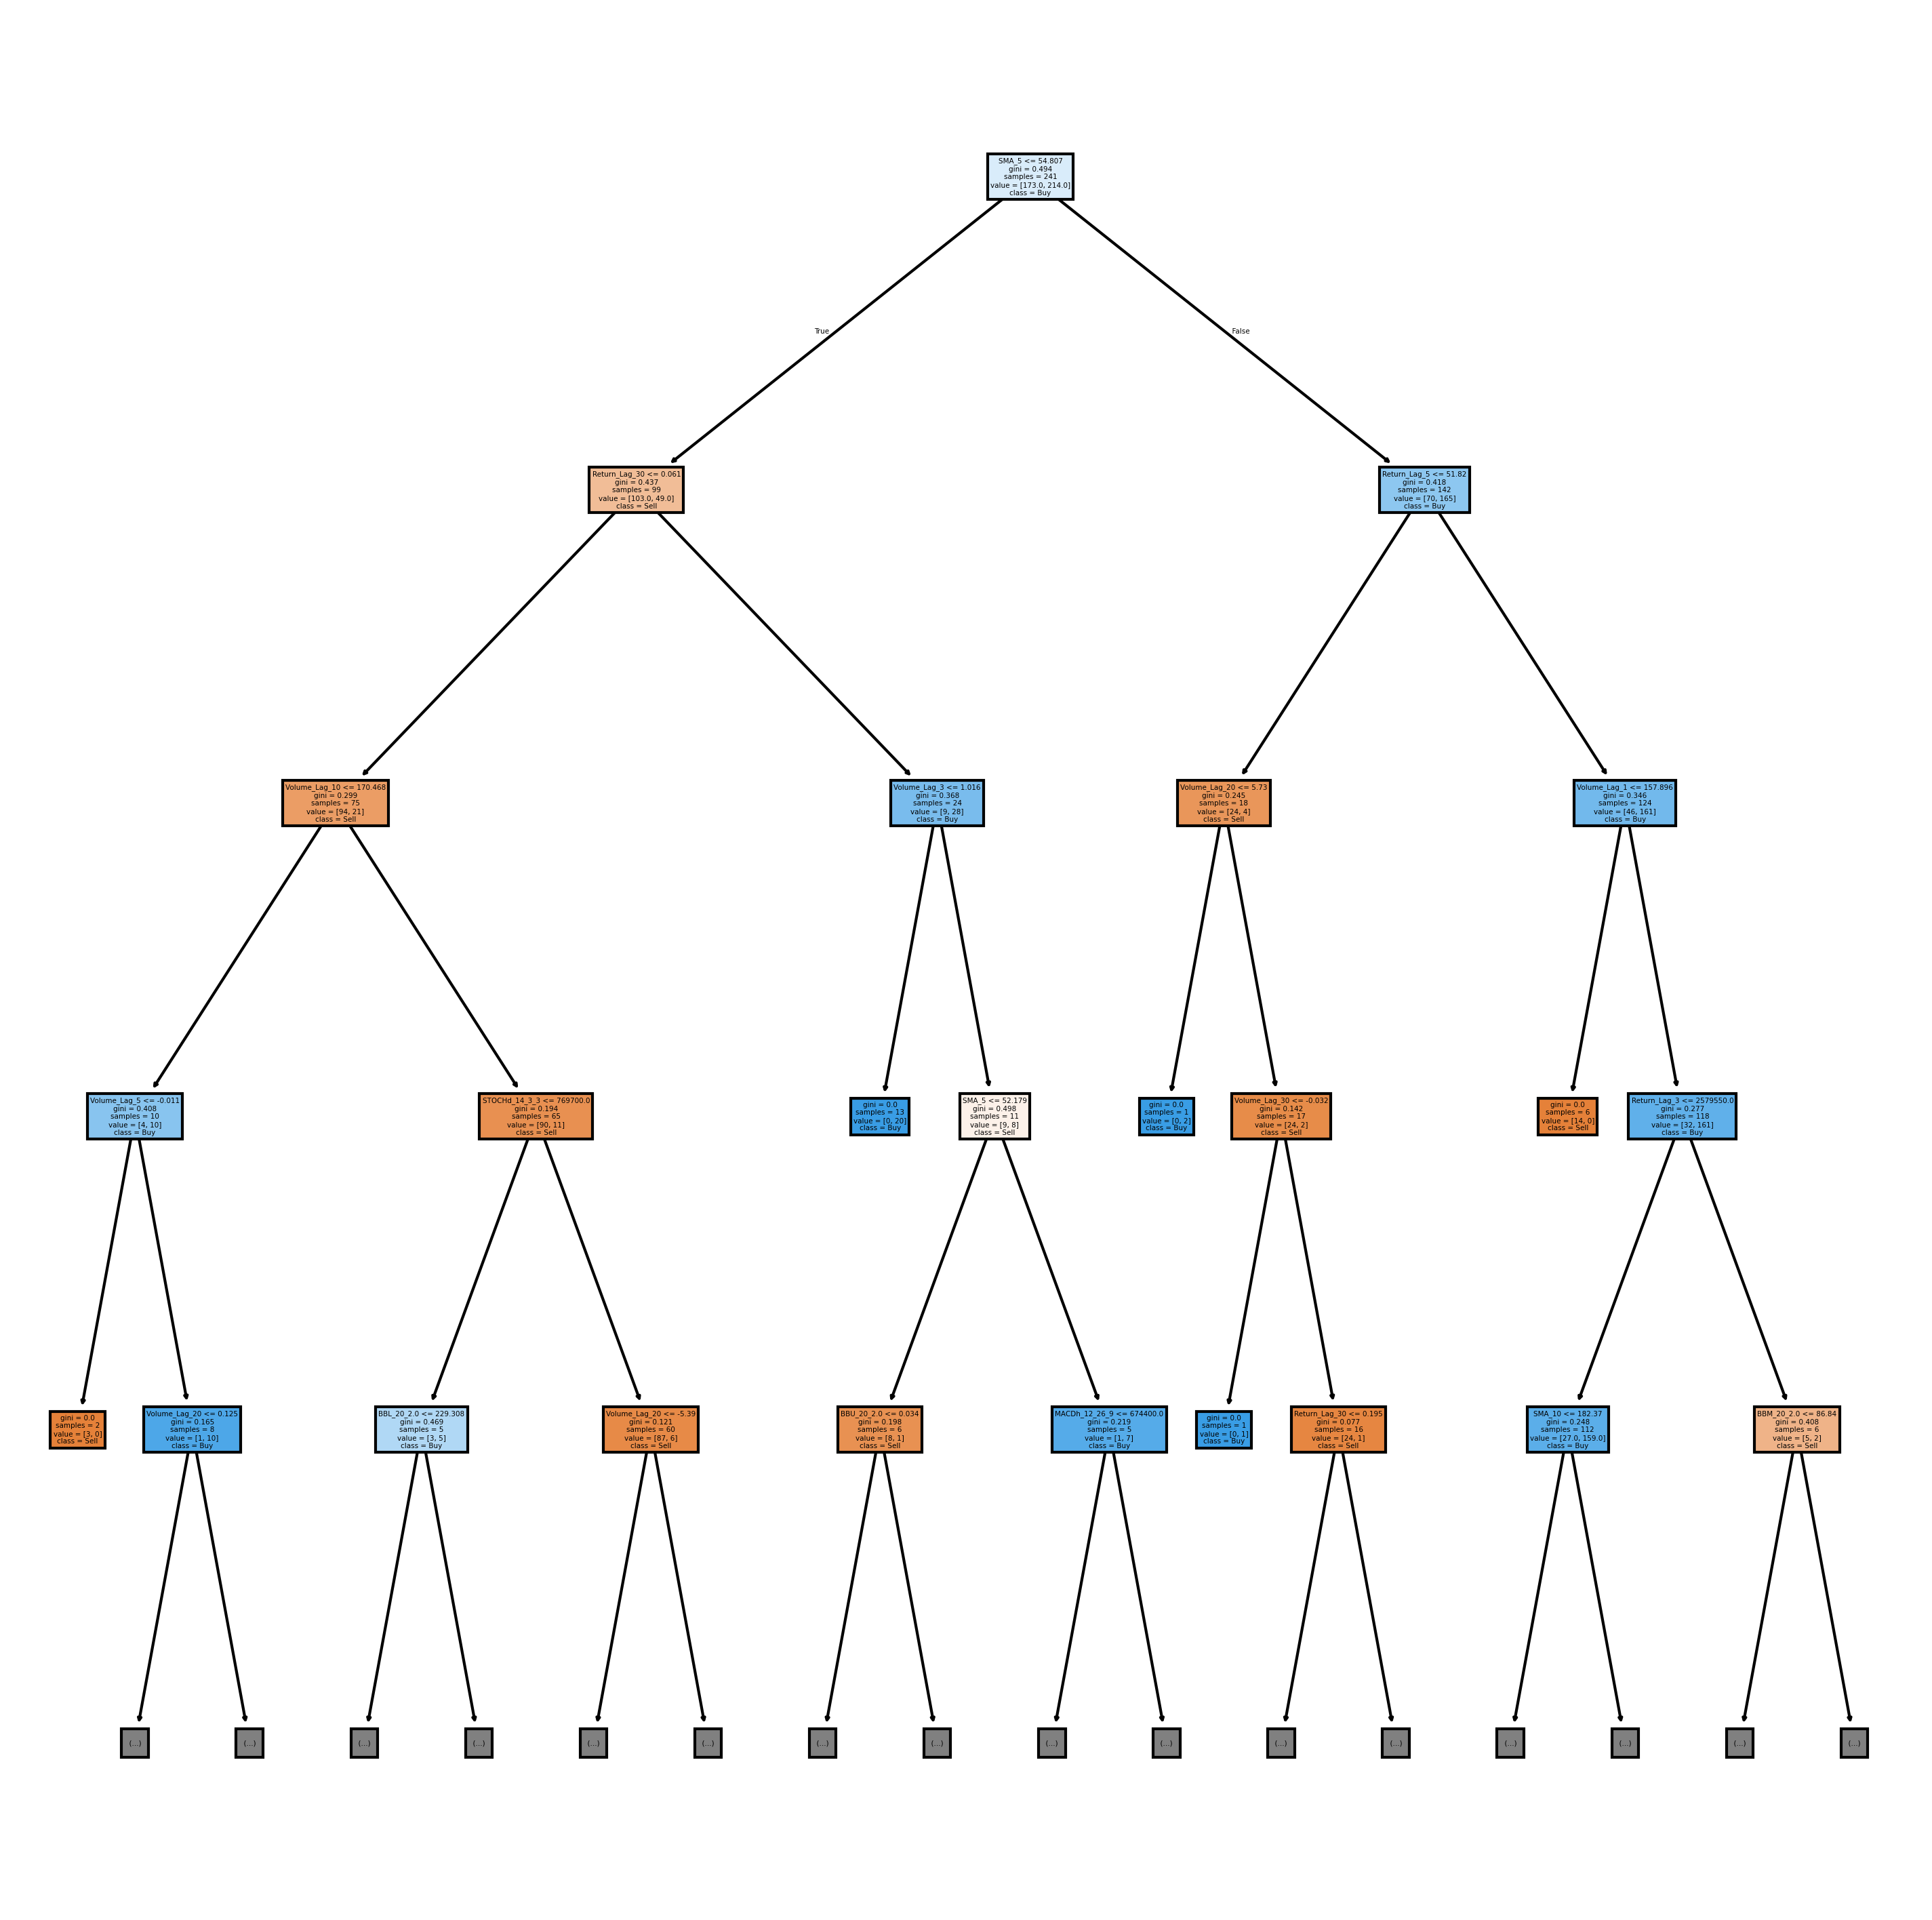

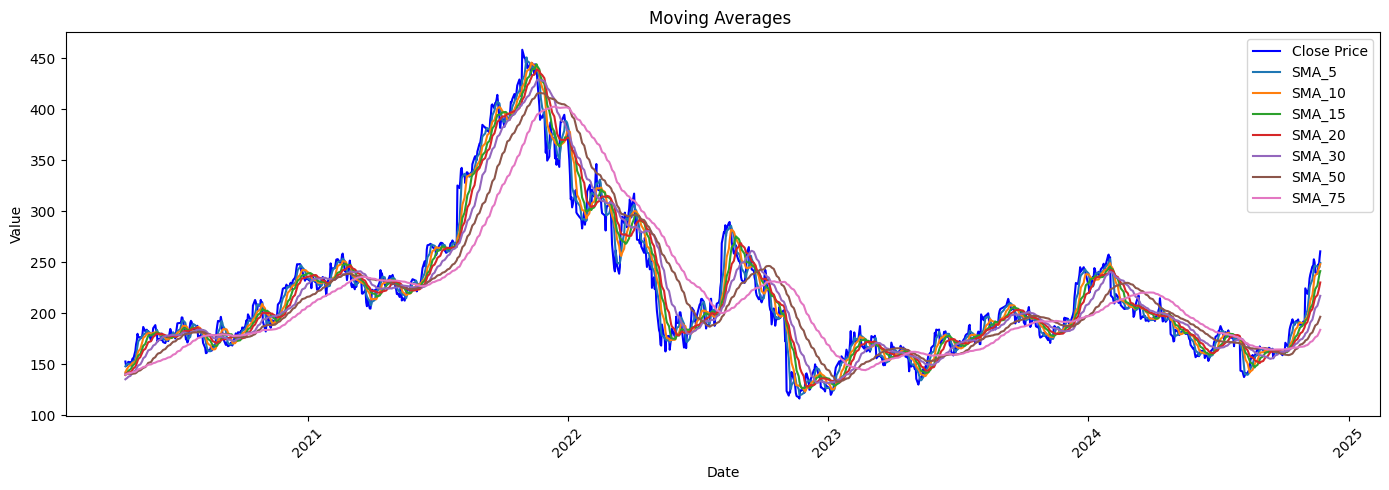

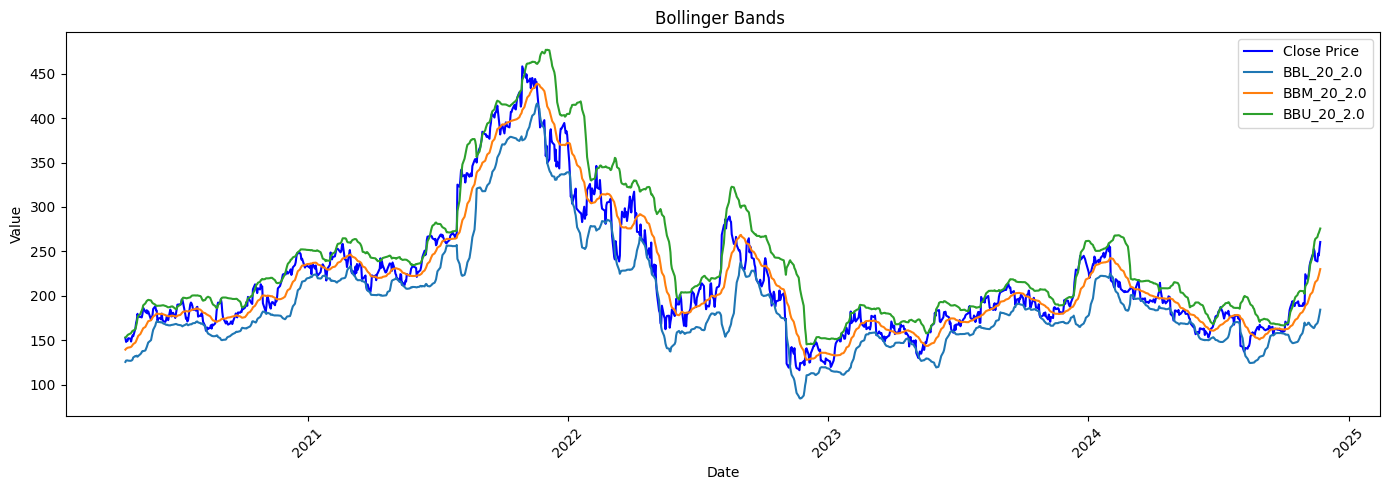

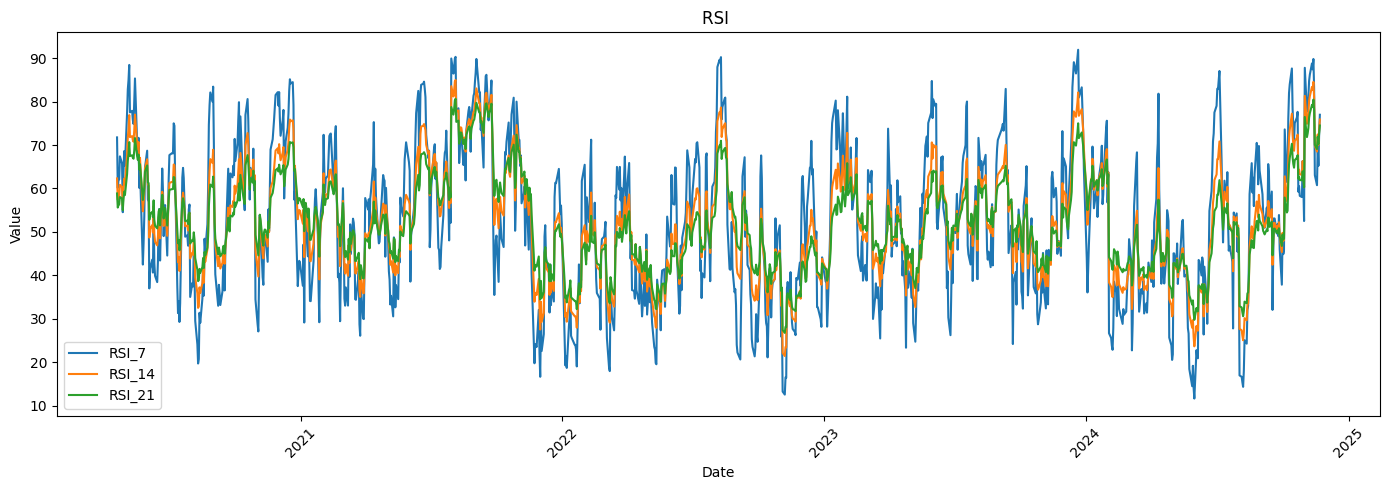

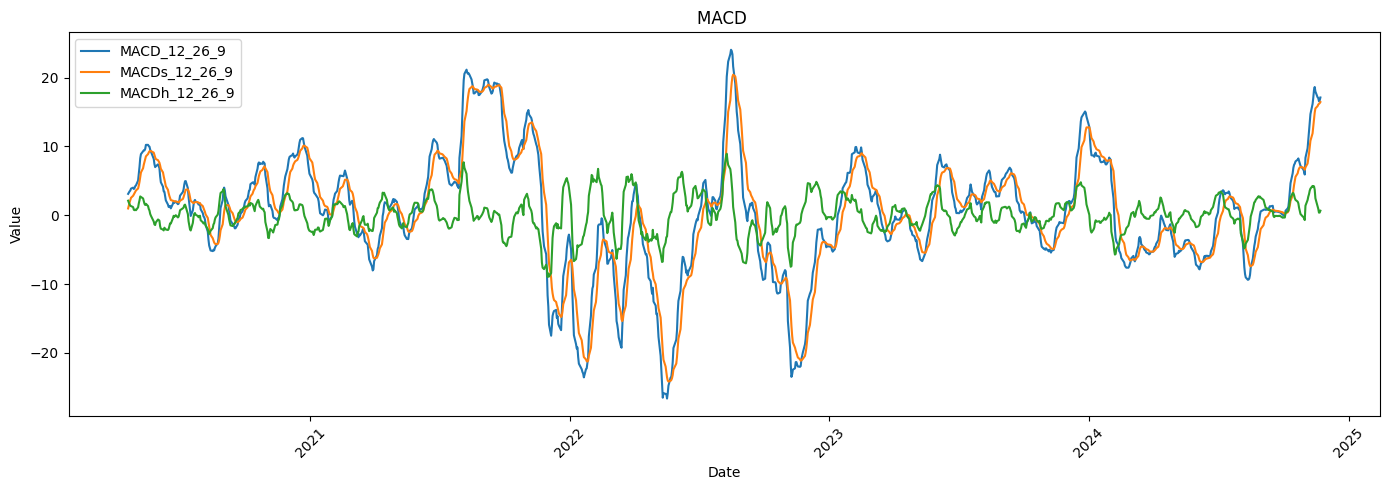

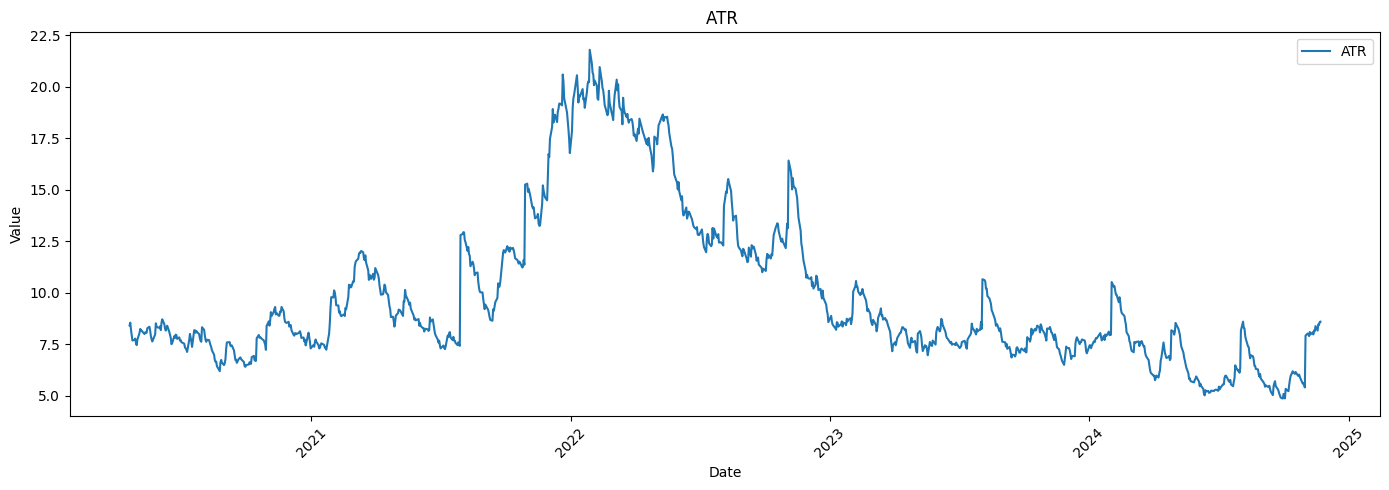

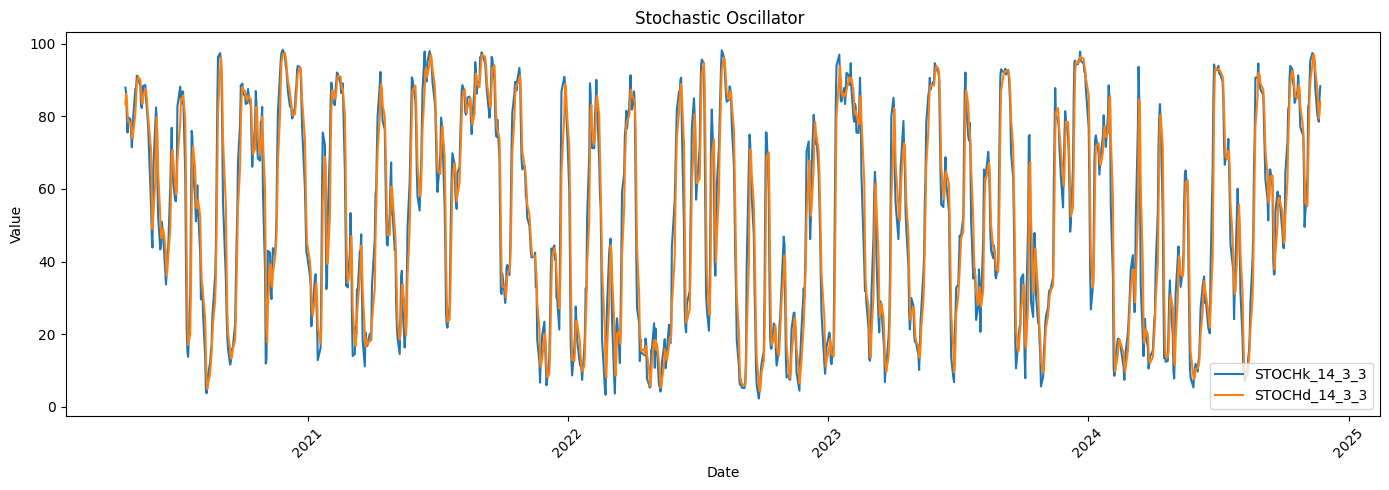

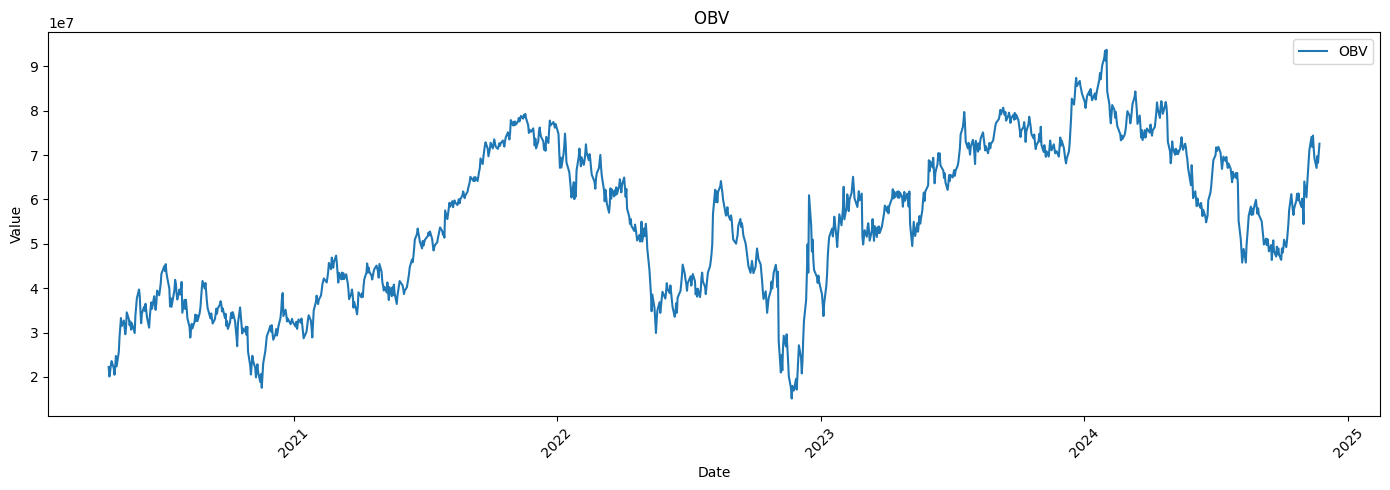

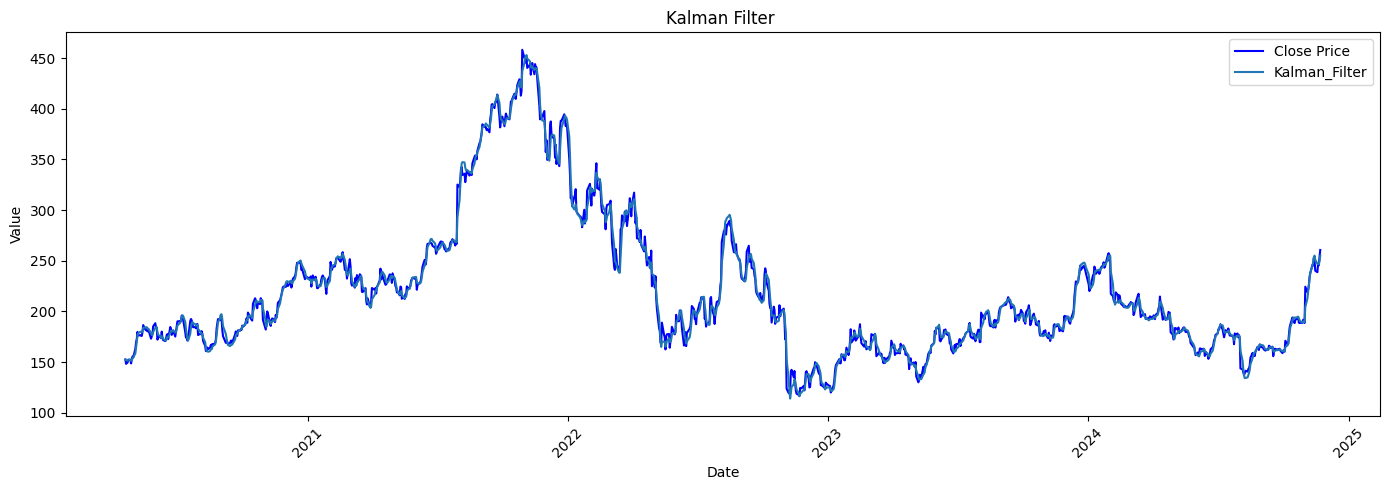

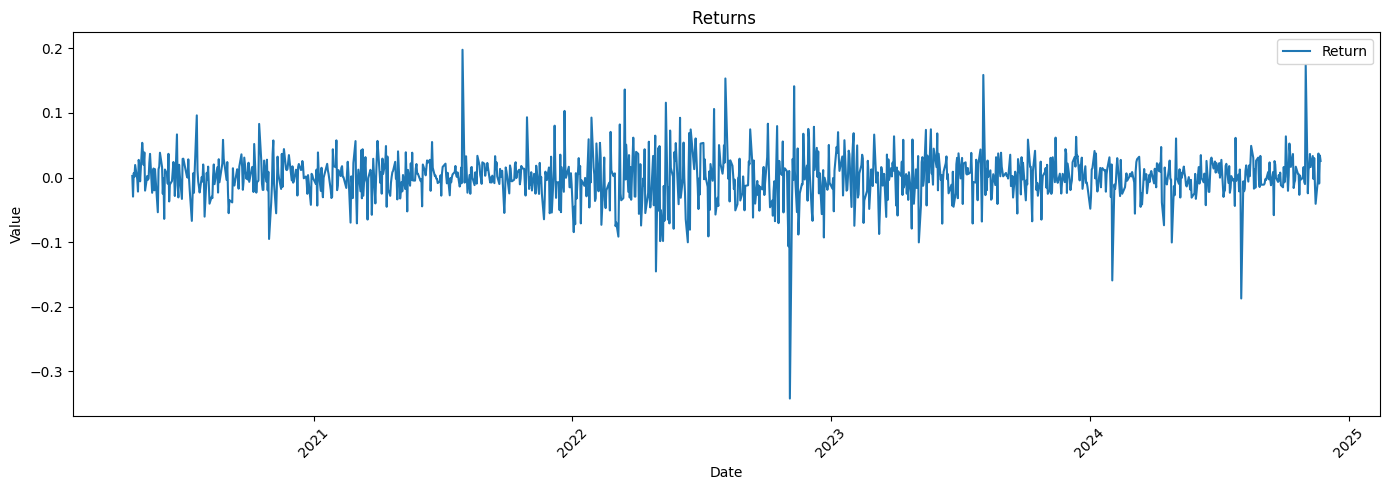

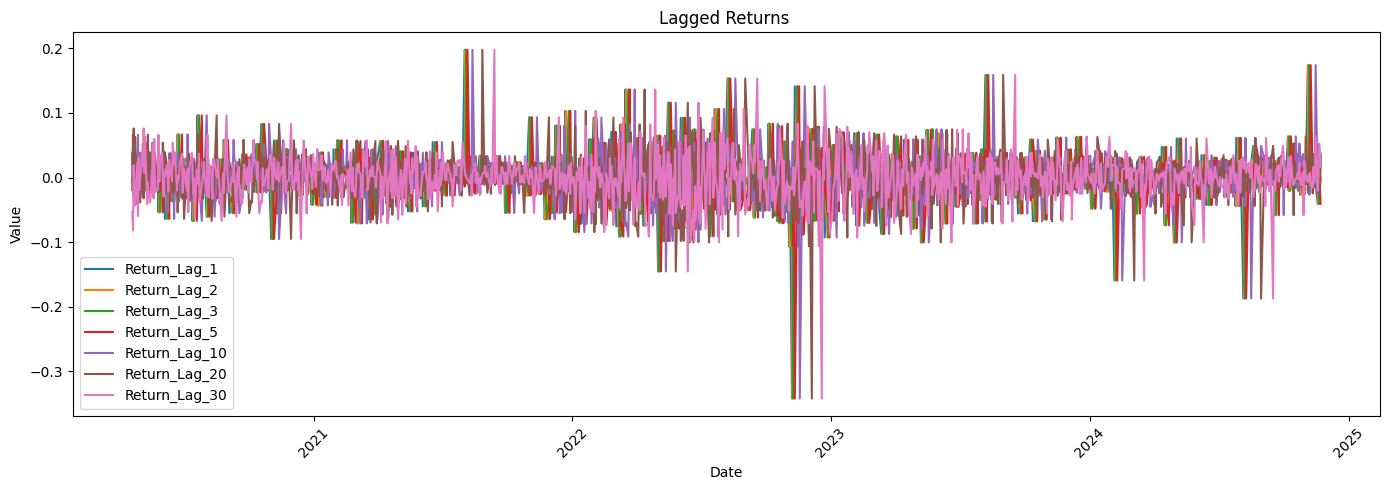

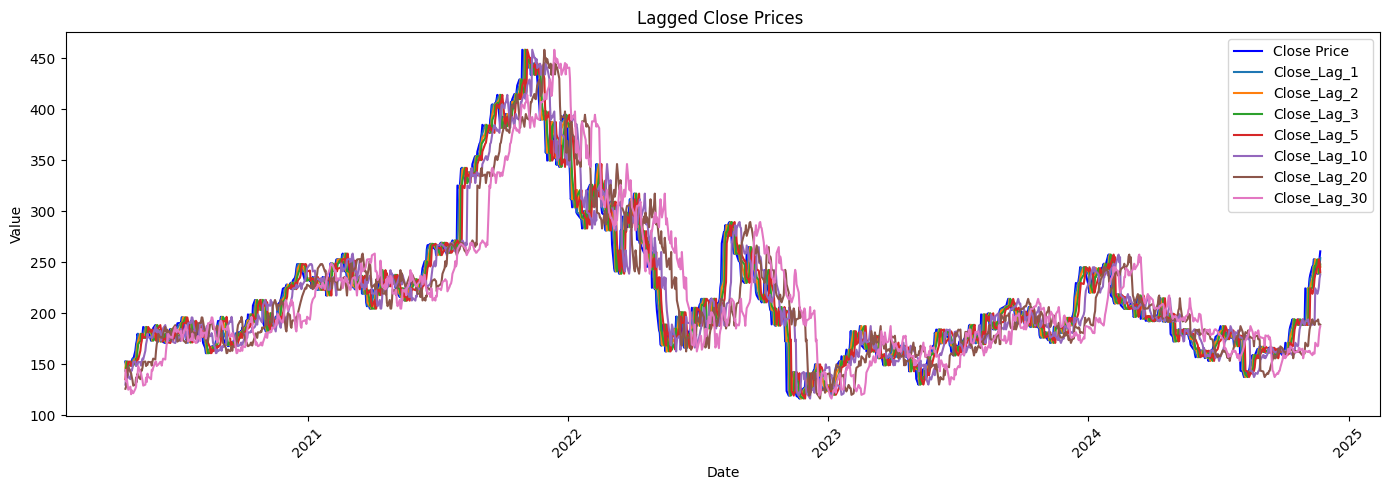

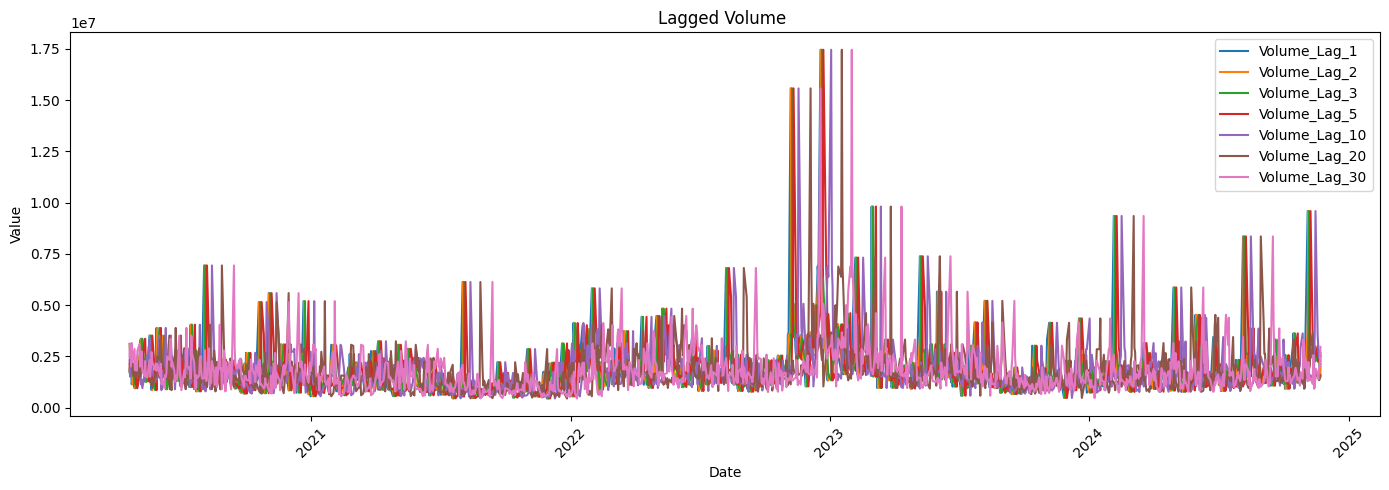

INFO:bokeh.io.state:Session output file 'backtest_results_random_forest_TEAM.html' already exists, will be overwritten.


Plotting the backtest results


In [8]:
def main():
    """
    ## Function: main
    ### Overview:
    Entry point for the script. Sets up the environment, retrieves stock data, and executes the chosen strategy.

    ### Hardcoded Parameters:
    - `model_to_run` (str): Name of the model to run (e.g., `'random_forest'`).
    - `ticker` (str): Stock ticker symbol for the analysis.
    - `start_date`, `end_date` (str): Date range for historical data retrieval.
    - `cash`, `commission`, `stop_loss_pct`, `take_profit_pct`: Trading parameters.
    - `trailing_stop`, `show_plots`, `save_logs`: Strategy behavior flags.
    - `run_hyperparameter_optimization` (bool): Whether to enable hyperparameter tuning.
    - `n_splits` (int): Number of time-series splits for cross-validation.
    - `features` (dict): Dictionary specifying the features to include in the model.

    ### Workflow:
    1. Initializes a `Features` object for data retrieval and feature engineering.
    2. Executes the `RandomForest` strategy workflow:
        - Target generation.
        - Model training and evaluation.
        - Signal generation and backtesting.
    3. Displays results visually and logs outputs to files.

    ### Notes:
    - Outputs plots and backtesting results in a format suitable for Jupyter Notebooks or standalone execution.
    - Saves key logs and trading signals to Excel files if enabled.
    """
    model_to_run = 'random_forest'
    ticker = 'TEAM'
    start_date='2020-01-01'
    end_date='2024-11-24'
    cash=10000
    commission=0.002
    stop_loss_pct=0.02
    take_profit_pct=0.25
    trailing_stop = False
    show_plots=True
    save_logs=True
    run_hyperparameter_optimization=False
    n_splits=2
    # [1, 2, 3, 5, 10, 20,30]:
    features = {
        # Returns
        'Return': False,

        # Volume Lag Features
        'Volume_Lag_1': True,
        'Volume_Lag_2': True,
        'Volume_Lag_3': True,
        'Volume_Lag_5': True,
        'Volume_Lag_10': True,
        'Volume_Lag_20': True,
        'Volume_Lag_30': True,
        # Close Price Lag Features
        'Close_Lag_1': True,
        'Close_Lag_2': True,
        'Close_Lag_3': True,
        'Close_Lag_5': True,
        'Close_Lag_10': True,
        'Close_Lag_20': False,
        'Close_Lag_30': False,
      # Return Lag Features
        'Return_Lag_1': True,
        'Return_Lag_2': True,
        'Return_Lag_3': True,
        'Return_Lag_5': True,
        'Return_Lag_10': True,
        'Return_Lag_20': True,
        'Return_Lag_30': True,

        # Relative Strength Index (RSI)
        'RSI_7': True,
        'RSI_14': True,
        'RSI_21': True,

        # Moving Averages
        'SMA_5': True,
        'SMA_10': True,
        'SMA_15': True,
        'SMA_20': True,
        'SMA_30': True,
        'SMA_50': True,
        'SMA_75': False, 

        # Bollinger Bands
        'BBL_20_2.0': True,
        'BBM_20_2.0': True,
        'BBU_20_2.0': True,
        'BBB_20_2.0': False,
        'BBP_20_2.0': False,

        # MACD (Moving Average Convergence Divergence)
        'MACD_12_26_9': True,
        'MACDs_12_26_9': True,
        'MACDh_12_26_9': True,

        # Stochastic Oscillator
        'STOCHk_14_3_3': True,
        'STOCHd_14_3_3': True,

        # Other Indicators
        'ATR': False,  # Average True Range
        'OBV': False,  # On-Balance Volume


    }
    
    if model_to_run == 'random_forest':
        number_of_features=None
        data = Features(ticker=ticker, start_date=start_date, end_date=end_date)
        rf = RandomForest(model=data,number_of_features=number_of_features,features=features,cash=cash, 
                          commission=commission,stop_loss_pct=stop_loss_pct,take_profit_pct=take_profit_pct,
                          show_plots=show_plots,save_logs=save_logs,run_hyperparameter_optimization=run_hyperparameter_optimization,
                          n_splits=n_splits,trailing_stop=trailing_stop)
        rf.run()
    

if __name__ == "__main__":
    main()

